Import modules
===

In [1]:
# standard modules
import numpy as np
from IPython.display import Image, display
from os import mkdir
from os.path import isdir, isfile

In [2]:
# custom package

# load the measurement schemes from the Benchmark
from shadowgrouping.measurement_schemes import Shadow_Grouping, Brute_force_matching, Derandomization, AdaptiveShadows, L1_sampler,  hit_by
from shadowgrouping.measurement_schemes import SettingSampler as Overlapped_Grouping
from shadowgrouping.AEQuO import AEQuO
from shadowgrouping.weight_functions import Inconfidence_bound, Bernstein_bound
# wrapper class to combine the measurement scheme with the respective outcomes
from shadowgrouping.energy_estimator import Energy_estimator, StateSampler, Sign_estimator, save_energy_estimations
# helper functions to load Hamiltonian decompositions
from shadowgrouping.measurement_schemes import setting_to_str
from shadowgrouping.hamiltonian import get_pauli_list, get_groundstate, char_to_int, int_to_char, mappings, load_pauli_list
import shadowgrouping.molecules as molecules
from shadowgrouping.benchmark import benchmark_empirical, benchmark_provable, save_dict, save_dict_provable

print(molecules.available_molecules)

['H2', 'H2_6-31g', 'LiH', 'BeH2', 'H2O', 'NH3']


C:\Users\aebad\AppData\Local\Temp\ipykernel_24632\883594277.py:13: NatureDeprecationWarning: The qiskit_nature.drivers.Molecule class is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.drivers.Molecule class.
  import shadowgrouping.molecules as molecules


Data I/O preparation
===

In [3]:
if not isdir("data/"):
    print("Data is zipped. Unzipping ...")
    !unzip -q data.zip
    print("Done!")

In [4]:
folder_Hamiltonians = "Hamiltonians/"
folder_OGM_settings = "OGM_probabilities/OGM_{}_{}{}.txt" # format string to fill in {molecule}x{qubit_number}x{mapping}
savepath = "generated_data/"
savename = "_molecule_{}_empirical.txt" # insert {mapping_name}

Molecule specifics
---

In [5]:
molecule_name = "H2" # choose one out of the molecules above
mapping_name = "JW" # choose one out of ["JW","BK","Parity"]
basis_set = "sto3g" # choose one out of ["sto3g","6-31g"] - the latter only for H2 molecule

Algorithm / Benchmark specifics
---

In [6]:
eps = 0.1 # accuracy in Hartree
NUM_STEPS = 1000 # number of total measurement settings
N_runs = 100 # number of sampling repetitions for the same settings
N_plot = 30 # number of data points taken for fig4
delta = 0.02 # see caption of Figure 3 in manuscript
alpha_offset = 1e-3 # parameter for ShadowGrouping
UPPER_LIMIT_BRUTE_FORCE = 8 # in number of qubits

Ensure availability of folder
---

In [7]:
savename = molecule_name + savename
# create temporary folder for storing outputs
if not isdir(savepath):
    mkdir(savepath)

Figure 2 - Truncation criterion
===
No data is used for generating this plot and no data is produced.

In [8]:
!python3 demo_fig2.py

C:\Users\aebad\shadowgrouping\demo_fig2.py:40: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('inconfidence level $\delta$',fontsize="x-large")
Traceback (most recent call last):
  File "C:\Users\aebad\shadowgrouping\demo_fig2.py", line 1, in <module>
    import numpy as np
ModuleNotFoundError: No module named 'numpy'


In [9]:
display(Image(filename="generated_figures/fig2_demo.png"))

FileNotFoundError: [Errno 2] No such file or directory: 'generated_figures/fig2_demo.png'

Table 1 - Empirical benchmark
===

In [10]:
# observables, w, offset, E_GS, state = load_pauli_list(folder_Hamiltonians,molecule_name,basis_set,mapping_name,verbose=True)
observables, w, offset, _, _ = load_pauli_list(folder_Hamiltonians,molecule_name,basis_set,mapping_name,verbose=True,diagonalize=False)
# wrap ground state <state> into StateSampler in order to retrieve samples in arbitrary
state_sampler = StateSampler(state)
# fill in format string for Overlapped Grouping probabilities
folder_OGM_settings = folder_OGM_settings.format(molecule_name,observables.shape[-1],mapping_name.lower())

# hyperparameters for ShadowGrouping, see eq. (48) in manuscript
alpha = np.max(np.abs(w))/np.min(np.abs(w)) + alpha_offset
#q = np.array([3, 0, 0, 0])
#p = np.array([0, 3, 0, 0])

Offset 		 -0.8105479805373261
ZIII 	 0.17218393261915566
IZII 	 -0.2257534922240248
IIZI 	 0.1721839326191557
IIIZ 	 -0.2257534922240248
ZZII 	 0.1209126326177663
YYXX 	 0.04523279994605781
YYYY 	 0.04523279994605781
XXXX 	 0.04523279994605781
XXYY 	 0.04523279994605781
ZIZI 	 0.16892753870087912
	 ...


NameError: name 'state' is not defined

In [11]:
# initialization of all methods used in the benchmark. The order corresponds to the one in Table I from left to right
methods = {}
methods["ShadowDerandomization"]     = Shadow_Grouping(observables,w,eps,Inconfidence_bound()())
methods["ShadowBernstein"]           = Shadow_Grouping(observables,w,eps,Bernstein_bound(alpha=alpha)())
methods["ShadowBernstein-truncated"] = Shadow_Grouping(observables,w,eps,Bernstein_bound(alpha=alpha)())
methods["Brute-force"]               = Brute_force_matching(observables,w,eps,Bernstein_bound(alpha=alpha)())
methods["Derandomization"]           = Derandomization(observables,w,eps,use_one_norm=True)
methods["RandomPaulis"]              = Derandomization(observables,w,eps,delta=1) # delta sets this method to random Paulis
methods["AdaptivePaulis"]            = AdaptiveShadows(observables,w)
methods["hit_by"]                    = hit_by(q,p)
methods["AEQuO"]                     = AEQuO(observables,w,offset,adaptiveness_L=2,interval_skewness_l=4,budget=NUM_STEPS) # values from figure 5 (L == adaptiveness_L +1)
# catch exception of missing data for OGM
file = folder_OGM_settings.format(molecule_name,observables.shape[1],mapping_name.lower())
if isfile(file):
    methods["OverlappedGrouping"]    = Overlapped_Grouping(observables,w,file)


NameError: name 'alpha' is not defined

Benchmarking all methods
---

In [12]:
# all details can be found in benchmark.py
results = {}
for label,method in methods.items():
    params = {"Nshots":NUM_STEPS, "Nreps": N_runs}
    if label=="Brute-force":
        if observables.shape[1] > UPPER_LIMIT_BRUTE_FORCE:
            continue
    elif label=="ShadowBernstein-truncated":
        params["truncate_delta"] = delta # indicate to use the truncation criterion
    elif label=="AEQuO":
        params["use_naive"] = True # numerical necessity for compatability between AEQuO and the rest of the API
    rmse, std, _ = benchmark_empirical(method,offset,state_sampler,E_GS,params)
    results[label] = (rmse,std)
    print("Data for label <{}> generated.".format(label))

NameError: name 'state_sampler' is not defined

In [13]:
# save data
# create temporary folder for storing outputs
if not isdir(savepath+"tab1/"):
    mkdir(savepath+"tab1/")
save_dict(savepath+"tab1/"+savename.format(mapping_name),results)
print("Empirical benchmark: data written to file")

Empirical benchmark: data written to file


Check outcomes
---
All previously generated data files can be easily accessed and displayed using the provided ```demo_*.py```-files
Using the ```-f <folder-name>``` option allows to look at the data generated and stored above.
If this option is left out, the data used for the manuscript is pulled up, instead

In [ ]:
!python3 demo_tab1.py -f generated_data/tab1/

Figure 4 - Provable benchmark
===

In [14]:
savename = savename.replace("empirical","provable")
# this benchmark does not require knowledge about the GS or its energy
observables, w, offset, _, _ = load_pauli_list(folder_Hamiltonians,molecule_name,basis_set,mapping_name,verbose=True,diagonalize=False)
# fill in format string for Overlapped Grouping probabilities
folder_OGM_settings = folder_OGM_settings.format(molecule_name,observables.shape[-1],mapping_name.lower())

# hyperparameters for ShadowGrouping, see eq. (48) in manuscript
alpha = np.max(np.abs(w))/np.min(np.abs(w)) + alpha_offset
#print (np.abs(w))

Offset 		 -0.8105479805373261
ZIII 	 0.17218393261915566
IZII 	 -0.2257534922240248
IIZI 	 0.1721839326191557
IIIZ 	 -0.2257534922240248
ZZII 	 0.1209126326177663
YYXX 	 0.04523279994605781
YYYY 	 0.04523279994605781
XXXX 	 0.04523279994605781
XXYY 	 0.04523279994605781
ZIZI 	 0.16892753870087912
	 ...


In [15]:
# initialization of all methods used in the benchmark. The order corresponds to the one in Table I from left to right
methods = {}
methods["ShadowDerandomization"]     = Shadow_Grouping(observables,w,eps,Inconfidence_bound()())
methods["ShadowBernstein"]           = Shadow_Grouping(observables,w,eps,Bernstein_bound(alpha=alpha)())
# its truncated version is already included in the benchmark method
methods["AdaptivePaulis"]            = AdaptiveShadows(observables,w)
# catch exception of missing data for OGM
file = folder_OGM_settings.format(molecule_name,observables.shape[1],mapping_name.lower())
if isfile(file):
    methods["OverlappedGrouping"]    = Overlapped_Grouping(observables,w,file)

Benchmarking all methods
---

In [ ]:
# all details can be found in benchmark.py
results = {}
for label,method in methods.items():
    params = {"Nshots":NUM_STEPS, "Nreps": N_runs, "Nsteps": N_plot}
    if label=="ShadowBernstein":
        params["truncate"] = True # indicate to use the truncation criterion
        Nsteps, epsilons, epsilons_truncated = benchmark_provable(method,delta,params)
        results[label+"-truncated"] = epsilons_truncated
        print("Data for label <{}-truncated> generated.".format(label))
    else:
        Nsteps, epsilons = benchmark_provable(method,delta,params)
    results[label] = epsilons
    print("Data for label <{}> generated.".format(label))

In [ ]:
# save data
# create temporary folder for storing outputs
if not isdir(savepath+"fig4/"):
    mkdir(savepath+"fig4/")
save_dict_provable(savepath+"fig4/"+savename.format(mapping_name),results,Nsteps)
print("Provable benchmark: data written to file")

Check outcomes
---
All previously generated data files can be easily accessed and displayed using the provided ```demo_*.py```-files
Using the ```-f <folder-name>``` option allows to look at the data generated and stored above.
If this option is left out, the data used for the manuscript is pulled up, instead

In [ ]:
!python3 demo_fig4.py -f generated_data/fig4/

In [ ]:
display(Image(filename="generated_figures/fig4_demo_{}.png".format(molecule_name)))

Note: if you only see one of three subplots filled, run the above code for ```mapping_name = "JW", "BK", "Parity"```

In [ ]:
!python3 demo_fig5.py

In [ ]:
display(Image(filename="generated_figures/fig5_demo.png"))

In [ ]:
# Assuming you have the `commute` function defined as before
#for i in range(len(observables)):
 #       weight = weight(observables[i])
        
# Print the result

        print np.abs(w)

# Qubit Wise Commutivity

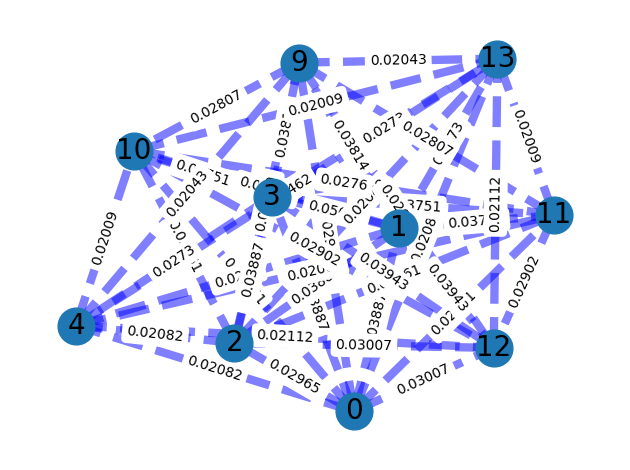

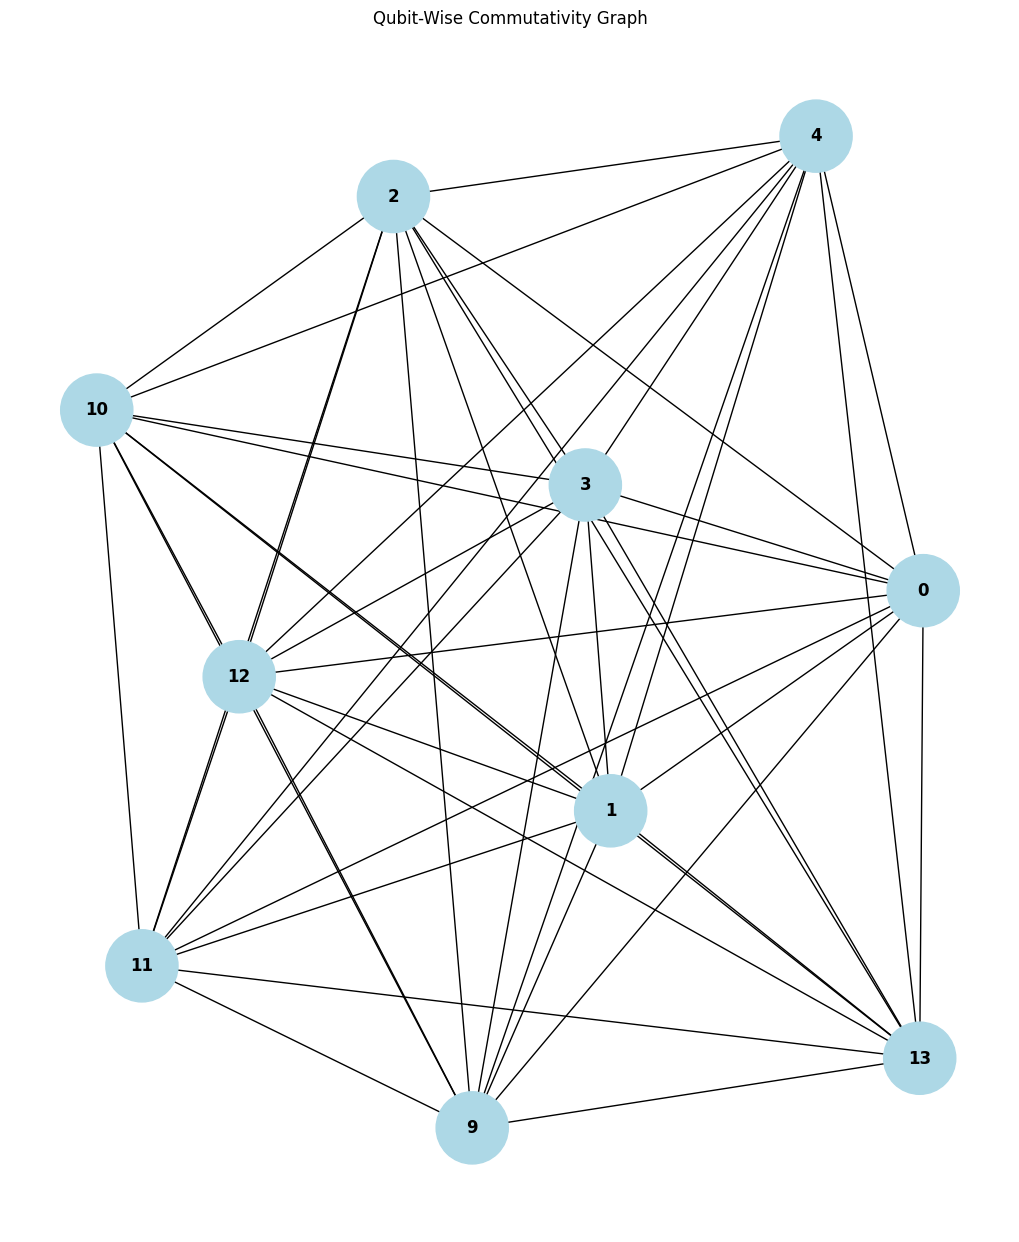

Number of edges: 45
Number of elements: 14
Sparsity of the graph: 0.4945054945054945
Edge weight sparsity of the graph: 0.8032168472455357
Node weight sparsity of the graph: 0.6261897116537052
Local Sparsity of the graph: 0.8032404888994479
A Dominating Set: {0}
Number of nodes in this dominating set: 1
Number of nodes in the minimum vertex cover: 9


In [16]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a graph
G = nx.Graph()

twe=0
tcwe=0
nwe=0
tnwe=0
lwe=0
tlwe=0


# Initialize wavg as a numpy array with the same length as observables
wavg = np.zeros(len(observables))

# Initialize neighbournum as a numpy array with the same length as observables
neighbournum = np.zeros(len(observables))


# Initialize nodeweight as a numpy array with the same length as observables
nodeweight = np.zeros(len(observables))


# Assuming you have the `hit_by` function defined as before
for i in range(len(observables)):
    tavg=0
    navg=0
    conn=0
    for j in range(i + 1, len(observables)):
        result = hit_by(observables[i], observables[j])
        #print(f"Observables {i} and {j} commute:", result)
        if hit_by(observables[i], observables[j]):
            we= round ((np.abs(w[i])*np.abs(w[j])),5)
            G.add_edge(i, j, weight=we)
            #add to total weight based on edge weights
            twe=twe+we
            #add to toal weight based on node weights
            nwe=nwe+np.abs(w[i])+np.abs(w[j])
            #add to general weight
            lwe=lwe+np.abs(w[i])*np.abs(w[j])
            #add to local weight
            tavg=tavg+np.abs(w[i])*np.abs(w[j])
            #number of connected nodes
            conn=conn+1
    wavg[i] = 0 if conn==0 else tavg/conn
    neighbournum[i] = conn
    nodeweight[i] = tavg
    
    




#calculate total edge and node weight if all the edges where connected
for i in range(len(observables)):
    for j in range(i+1,len(observables)):
        tcwe=round((np.abs(w[i])*np.abs(w[j])),5)+tcwe
        tnwe=np.abs(w[i])+np.abs(w[j])+tnwe
        tlwe=np.abs(w[i])*np.abs(w[j])+tlwe


elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=10)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

# Draw and display the graph
#nx.draw(G, with_labels=True, font_weight='bold')
#plt.show()


#G.add_nodes_from(range(len(observables)))


# Calculate node sizes based on node degrees
node_degrees = dict(G.degree())
node_sizes = [300 * node_degrees[node] for node in G.nodes()]


#Draw and display the graph
plt.figure(figsize=(10, 12))
nx.draw(G, with_labels=True, font_weight='bold', node_color='lightblue', node_size=node_sizes)
plt.title("Qubit-Wise Commutativity Graph")
plt.savefig('qubitwisecomm.png', dpi=300)
plt.show()




# Calculate sparsity
num_elements = len(observables)
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
sparsity = 0 if num_elements == 0 else (2 * num_edges) / (num_elements * (num_elements - 1))
wsparsity = 0 if tcwe == 0 else twe/tcwe
nsparsity = 0 if tnwe == 0 else nwe/tnwe
lsparsity = 0 if tlwe == 0 else lwe/tlwe
#avgweight = lwe/conn

#print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Number of elements:", num_elements)
print("Sparsity of the graph:", sparsity)
print("Edge weight sparsity of the graph:", wsparsity)
print("Node weight sparsity of the graph:", nsparsity)
print("Local Sparsity of the graph:", lsparsity)
#print("average weight of the nodes:", avgweight)



# Print the total number of elements in observables
#total_elements = len(observables)
#print("Total number of elements in observables:", total_elements)

#print node degrees
#print("Node Degrees:")
#for node, degree in node_degrees.items():
#    print(f"Node {node}: Degree {degree}")



# Find a dominating set (a set D of nodes such that every node in the graph is either in D or adjacent to a node in D)
# This function finds some dominating set, not necessarily the smallest one.
min_dominating_set = nx.dominating_set(G)

# Print the minimum dominating set
print("A Dominating Set:", min_dominating_set)
print("Number of nodes in this dominating set:", len(min_dominating_set))


# Function to check if a matrix is Hermitian
#def is_hermitian(matrix):
    # Check if the matrix is equal to its conjugate transpose
 #   return np.allclose(matrix, np.conj(matrix).T)

# Iterate over each observable and check if it is Hermitian
#for i, observable in enumerate(observables):
#    if is_hermitian(observable):
 #       print(f"Observable {i} is Hermitian.")
  #  else:
   #     print(f"Observable {i} is not Hermitian.")


# Find the minimum vertex cover (In an MVC, the selected set of nodes covers all edges in the graph)
min_vertex_cover = nx.algorithms.approximation.vertex_cover.min_weighted_vertex_cover(G)

# Print the minimum vertex cover
#print("Minimum Vertex Cover:", min_vertex_cover)
print("Number of nodes in the minimum vertex cover:", len(min_vertex_cover))



# Sorting the Nodes (for QWC)

In [17]:
#Change the Minimum Dominating Set problem to Sorting Problem


#Timsort is a hybrid sorting algorithm derived from merge sort and insertion sort. It is designed to perform well on many kinds of real-world data.

# Sort nodes based on number of neighbours
nsorted_indices = sorted(range(len(neighbournum)), key=lambda x: neighbournum[x], reverse=True)

# Print sorted nodes and their number of neighbours
print("Nodes sorted by number of neighbours:")
for index in nsorted_indices:
    print(f"Node {index}: number of neighbours = {neighbournum[index]}")


# Sort nodes based on node total weight
wsorted_indices = sorted(range(len(nodeweight)), key=lambda x: nodeweight[x], reverse=True)

# Print sorted nodes and their number of neighbours
print("Nodes sorted by node total weights:")
for index in wsorted_indices:
    print(f"Node {index}: total weight = {nodeweight[index]}")


# Sort nodes based on their average weight
asorted_indices = sorted(range(len(wavg)), key=lambda x: wavg[x], reverse=True)

# Print sorted nodes and their average weights
print("Nodes sorted by average weight:")
for index in asorted_indices:
    print(f"Node {index}: average weight = {wavg[index]}")

Nodes sorted by number of neighbours:
Node 0: number of neighbours = 9.0
Node 1: number of neighbours = 8.0
Node 2: number of neighbours = 7.0
Node 3: number of neighbours = 6.0
Node 4: number of neighbours = 5.0
Node 9: number of neighbours = 4.0
Node 10: number of neighbours = 3.0
Node 11: number of neighbours = 2.0
Node 12: number of neighbours = 1.0
Node 5: number of neighbours = 0.0
Node 6: number of neighbours = 0.0
Node 7: number of neighbours = 0.0
Node 8: number of neighbours = 0.0
Node 13: number of neighbours = 0.0
Nodes sorted by node total weights:
Node 1: total weight = 0.2970068308818201
Node 0: total weight = 0.26540052858779595
Node 3: total weight = 0.20717106753683673
Node 2: total weight = 0.19688209784195754
Node 9: total weight = 0.10606063630031984
Node 4: total weight = 0.09634009842322133
Node 10: total weight = 0.07670959474578774
Node 11: total weight = 0.04910528998396753
Node 12: total weight = 0.021116596973280454
Node 5: total weight = 0.0
Node 6: total w

# Finding minimum dominating set (for QWC)

In [18]:
#Greedy algorithms for MDS based on node degrees and node weights


import networkx as nx



#finding dominating set, searching based on node degrees
def greedy_ndominating_set(F):
    # Step 1: Calculate the degree of each node
    node_degrees = dict(F.degree())
    
    # Step 2: Initialize dominating set and covered nodes
    ndominating_set = set()
    ncovered_nodes = set()
    
    for node in nsorted_indices:
        if len(ncovered_nodes) == len(F.nodes):
            break
        if node not in ncovered_nodes:
            # Add node to dominating set
            ndominating_set.add(node)
            # Mark the node and its neighbors as covered
            ncovered_nodes.add(node)
            ncovered_nodes.update(F.neighbors(node))
    
    return ndominating_set

ndominating_set = greedy_ndominating_set(G)
print("Dominating Set by Degrees:", ndominating_set)


#finding dominating set, searching based on node weights
def greedy_wdominating_set(F):
    # Step 1: Calculate the degree of each node
    node_degrees = dict(F.degree())
    
    # Step 2: Initialize dominating set and covered nodes
    wdominating_set = set()
    wcovered_nodes = set()
    
    for node in wsorted_indices:
        if len(wcovered_nodes) == len(F.nodes):
            break
        if node not in wcovered_nodes:
            # Add node to dominating set
            wdominating_set.add(node)
            # Mark the node and its neighbors as covered
            wcovered_nodes.add(node)
            wcovered_nodes.update(F.neighbors(node))
    
    return wdominating_set

wdominating_set = greedy_wdominating_set(G)
print("Dominating Set by Weights:", wdominating_set)


#finding dominating set, searching based on node average weights
def greedy_adominating_set(F):
    # Step 1: Calculate the degree of each node
    node_degrees = dict(F.degree())
    
    # Step 2: Initialize dominating set and covered nodes
    adominating_set = set()
    acovered_nodes = set()
    
    for node in asorted_indices:
        if len(acovered_nodes) == len(F.nodes):
            break
        if node not in acovered_nodes:
            # Add node to dominating set
            adominating_set.add(node)
            # Mark the node and its neighbors as covered
            acovered_nodes.add(node)
            acovered_nodes.update(F.neighbors(node))
    
    return adominating_set

adominating_set = greedy_adominating_set(G)
print("Dominating Set by Average Weights:", adominating_set)

Dominating Set by Degrees: {0}
Dominating Set by Weights: {1}
Dominating Set by Average Weights: {1}


# Cliques based on dominating set (for QWC)

In [19]:
#find local cliques based on dominating set

import networkx as nx
from networkx.algorithms.clique import find_cliques
import time  # Import the time module


# Start measuring time
start_time = time.time()


# Temporarily remove edges between nodes in the dominating set
G_temp = G.copy()
for u in ndominating_set:
    for v in ndominating_set:
        if u != v and G_temp.has_edge(u, v):
            G_temp.remove_edge(u, v)


def local_cliques_around_node(G, node):
    neighbors = list(G.neighbors(node))
    subgraph_nodes = neighbors + [node]
    subgraph = G.subgraph(subgraph_nodes)
    cliques = list(find_cliques(subgraph))
    return cliques

total_cliques = 0
cliques = {}
total_nodes_in_cliques = 0

all_local_cliques = {}
for node in ndominating_set:
    all_local_cliques[node] = local_cliques_around_node(G_temp, node)
    total_cliques += len(all_local_cliques[node])
    total_nodes_in_cliques += sum(len(clique) for clique in all_local_cliques[node])


# Calculate average number of nodes in the cliques
average_nodes_in_cliques = total_nodes_in_cliques / total_cliques if total_cliques > 0 else 0


# Collect all nodes in these cliques
covered_nodes = set()
for cliques in all_local_cliques.values():
    for clique in cliques:
        covered_nodes.update(clique)

# Check if all nodes in the graph are covered
all_nodes_covered = set(G.nodes) == covered_nodes


# End measuring time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time


print("Local cliques around nodes in the dominating set:")
for node, cliques in all_local_cliques.items():
    print(f"Node {node}: {cliques}")


print("Covered nodes:", covered_nodes)
print("All nodes covered:", all_nodes_covered)
print("Total number of cliques:", total_cliques)
print("Average number of nodes in these cliques:", average_nodes_in_cliques)
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Local cliques around nodes in the dominating set:
Node 0: [[0, 1, 2, 3, 4, 9, 10, 11, 12, 13]]
Covered nodes: {0, 1, 2, 3, 4, 9, 10, 11, 12, 13}
All nodes covered: True
Total number of cliques: 1
Average number of nodes in these cliques: 10.0
Elapsed time: 0.0014 seconds


# Minimize Number of Cliques (for QWC)

In [20]:
#Minimize the number of cliques while covering the whole graph using Greedy Algorithm

import networkx as nx
from networkx.algorithms.clique import find_cliques
from itertools import combinations
import time

# Start measuring time
start_time = time.time()

# Flatten all local cliques into a single list
local_cliques = [clique for cliques in all_local_cliques.values() for clique in cliques]

# Initialize the set of covered nodes
covered_nodes = set()

# Keep track of the selected cliques
selected_cliques = []

def cover_nodes_with_cliques(cliques, G):
    uncovered_nodes = set(G.nodes)
    selected_cliques = []
    while uncovered_nodes:
        # Find the clique that covers the most uncovered nodes
        best_clique = None
        best_cover = 0
        for clique in cliques:
            cover = len(set(clique) & uncovered_nodes)
            if cover > best_cover:
                best_cover = cover
                best_clique = clique
        
        if best_clique is None:
            break
        
        # Add the best clique to the selected cliques
        selected_cliques.append(best_clique)
        covered_nodes.update(best_clique)
        uncovered_nodes.difference_update(best_clique)
    
    return selected_cliques

# Find the minimum number of cliques to cover the entire graph
selected_cliques = cover_nodes_with_cliques(local_cliques, G)

# End measuring time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print results
print("Minimum number of cliques to cover the entire graph:", len(selected_cliques))
for clique in selected_cliques:
    print(list(clique))

print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Calculate covered nodes
covered_nodes = set()
for clique in selected_cliques:
    covered_nodes.update(clique)

# Check if all nodes are covered
all_nodes_covered = set(G.nodes) == covered_nodes


print("All nodes covered:", all_nodes_covered)
if all_nodes_covered:
    print(f"Covered nodes: {covered_nodes}")
else:
    print("Some nodes are not covered.")

Minimum number of cliques to cover the entire graph: 1
[0, 1, 2, 3, 4, 9, 10, 11, 12, 13]
Elapsed time: 0.0000 seconds
All nodes covered: True
Covered nodes: {0, 1, 2, 3, 4, 9, 10, 11, 12, 13}


# General Commutivity

Observables 0 and 1 commute : True
Observables 0 and 2 commute : True
Observables 0 and 3 commute : True
Observables 0 and 4 commute : True
Observables 0 and 5 commute : False
Observables 0 and 6 commute : False
Observables 0 and 7 commute : False
Observables 0 and 8 commute : False
Observables 0 and 9 commute : True
Observables 0 and 10 commute : True
Observables 0 and 11 commute : True
Observables 0 and 12 commute : True
Observables 0 and 13 commute : True
Observables 1 and 2 commute : True
Observables 1 and 3 commute : True
Observables 1 and 4 commute : True
Observables 1 and 5 commute : False
Observables 1 and 6 commute : False
Observables 1 and 7 commute : False
Observables 1 and 8 commute : False
Observables 1 and 9 commute : True
Observables 1 and 10 commute : True
Observables 1 and 11 commute : True
Observables 1 and 12 commute : True
Observables 1 and 13 commute : True
Observables 2 and 3 commute : True
Observables 2 and 4 commute : True
Observables 2 and 5 commute : False
Obs

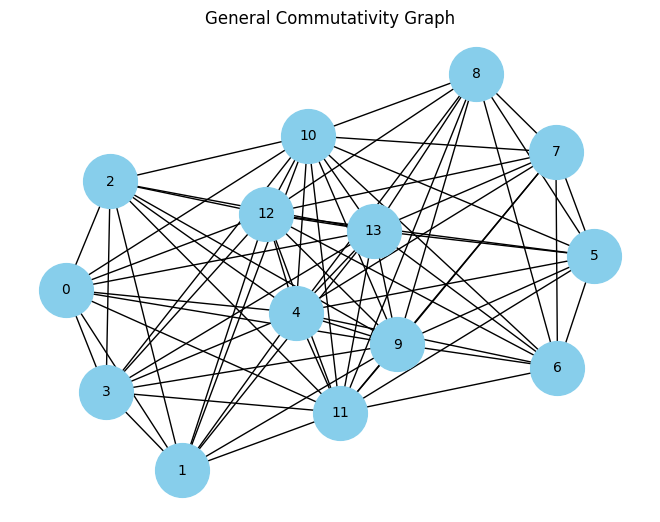

Total number of elements in observables: 14
Number of nodes: 14
Number of edges: 75
Sparsity of the graph: 0.8241758241758241
Edge weight sparsity of the graph: 0.912101327636197
Node weight sparsity of the graph: 0.8413529720846279
A Dominating Set: {0, 8}
Number of nodes in this dominating set: 2


In [21]:
#general commutivity

import networkx as nx
import matplotlib.pyplot as plt


# Create a graph
H = nx.Graph()


gtwe=0
gtcwe=0
gnwe=0
gtnwe=0
glwe=0
gtlwe=0

# Initialize gwavg as a numpy array with the same length as observables
gwavg = np.zeros(len(observables))


# Initialize gneighbournum as a numpy array with the same length as observables
gneighbournum = np.zeros(len(observables))

# Initialize gnodeweight as a numpy array with the same length as observables
gnodeweight = np.zeros(len(observables))

def gcomm(O, P):
    """ Returns whether the number of failed commuting pairs in O and P is even """
    fail_commuting_count = 0
    for o, p in zip(O, P):
        if not (o==0 or p==0 or o==p) :
            fail_commuting_count += 1
    #print(f"Fail_Commuting count for {O} and {P}: {fail_commuting_count}")  # Print the commuting count
    return fail_commuting_count % 2 == 0  # Check if the fail to commute in even number of indices


# Checking pairs of observables
for i in range(len(observables)):
    gtavg=0
    gnavg=0
    gconn=0
    for j in range(i + 1, len(observables)):
        result = gcomm(observables[i], observables[j])
        print(f"Observables {i} and {j} commute : {result}")
        if result:
            gwe= round ((np.abs(w[i])*np.abs(w[j])),5)
            H.add_edge(i, j)
            #add to total weight based on edge weights
            gtwe=gtwe+gwe
            #add to total weight based on node weights
            gnwe=gnwe+np.abs(w[i])+np.abs(w[j])
            #add to general weight
            glwe=lwe+np.abs(w[i])*np.abs(w[j])
            #add to local weight
            gtavg=tavg+np.abs(w[i])*np.abs(w[j])
            #number of connected nodes
            gconn=gconn+1
    gwavg[i] = 0 if gconn==0 else gtavg/gconn
    gneighbournum[i] = gconn
    gnodeweight[i] = gtavg


#calculate total edge and node weight if all the edges where connected
for i in range(len(observables)):
    for j in range(i+1,len(observables)):
        gtcwe=round((np.abs(w[i])*np.abs(w[j])),5)+gtcwe
        gtnwe=np.abs(w[i])+np.abs(w[j])+gtnwe


# Draw the graph
nx.draw(H, with_labels=True, node_color='skyblue', node_size=1500, font_size=10)
plt.title('General Commutativity Graph')
plt.savefig('generalcomm.png', dpi=300)
plt.show()



# Calculate sparsity
num_nodes = H.number_of_nodes()
num_elements = len(observables)
num_edges = H.number_of_edges()
sparsity = 0 if num_elements == 0 else (2 * num_edges) / (num_elements * (num_elements - 1))
gwsparsity = 0 if gtcwe == 0 else gtwe/gtcwe
gnsparsity = 0 if gtnwe == 0 else gnwe/gtnwe

# Print the total number of elements in observables
print("Total number of elements in observables:", num_elements)
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Sparsity of the graph:", sparsity)
print("Edge weight sparsity of the graph:", gwsparsity)
print("Node weight sparsity of the graph:", gnsparsity)



# Find a dominating set (a set D of nodes such that every node in the graph is either in D or adjacent to a node in D)
# This function finds some dominating set, not necessarily the smallest one.
min_dominating_set = nx.dominating_set(H)

# Print the minimum dominating set
print("A Dominating Set:", min_dominating_set)
print("Number of nodes in this dominating set:", len(min_dominating_set))

# Sorting the Nodes (for GC)

In [22]:
#Change the Minimum Dominating Set problem to Sorting Problem


#Timsort is a hybrid sorting algorithm derived from merge sort and insertion sort. It is designed to perform well on many kinds of real-world data.

# Sort nodes based on number of neighbours
gnsorted_indices = sorted(range(len(gneighbournum)), key=lambda x: gneighbournum[x], reverse=True)

# Print sorted nodes and their number of neighbours
print("Nodes sorted by number of neighbours:")
for index in gnsorted_indices:
    print(f"Node {index}: number of neighbours = {gneighbournum[index]}")


# Sort nodes based on node total weight
gwsorted_indices = sorted(range(len(gnodeweight)), key=lambda x: gnodeweight[x], reverse=True)

# Print sorted nodes and their number of neighbours
print("Nodes sorted by node total weights:")
for index in gwsorted_indices:
    print(f"Node {index}: total weight = {gnodeweight[index]}")


# Sort nodes based on their average weight
gasorted_indices = sorted(range(len(gwavg)), key=lambda x: gwavg[x], reverse=True)

# Print sorted nodes and their average weights
print("Nodes sorted by average weight:")
for index in gasorted_indices:
    print(f"Node {index}: average weight = {gwavg[index]}")

Nodes sorted by number of neighbours:
Node 0: number of neighbours = 9.0
Node 4: number of neighbours = 9.0
Node 1: number of neighbours = 8.0
Node 5: number of neighbours = 8.0
Node 2: number of neighbours = 7.0
Node 6: number of neighbours = 7.0
Node 3: number of neighbours = 6.0
Node 7: number of neighbours = 6.0
Node 8: number of neighbours = 5.0
Node 9: number of neighbours = 4.0
Node 10: number of neighbours = 3.0
Node 11: number of neighbours = 2.0
Node 12: number of neighbours = 1.0
Node 13: number of neighbours = 0.0
Nodes sorted by node total weights:
Node 1: total weight = 0.027296449067461273
Node 3: total weight = 0.027296449067461273
Node 12: total weight = 0.021116596973280454
Node 2: total weight = 0.0208192125874622
Node 0: total weight = 0.020819212587462194
Node 9: total weight = 0.020425473425962896
Node 10: total weight = 0.02008908164870953
Node 11: total weight = 0.02008908164870953
Node 4: total weight = 0.014619864726558924
Node 5: total weight = 0.005469216922

# Finding minimum dominating set (for GC)

In [23]:
#Greedy algorithms for MDS based on node degrees and node weights


import networkx as nx



#finding dominating set, searching based on node degrees
def greedy_ndominating_set(F):
    # Step 1: Calculate the degree of each node
    node_degrees = dict(F.degree())
    
    # Step 2: Initialize dominating set and covered nodes
    gndominating_set = set()
    gncovered_nodes = set()
    
    for node in gnsorted_indices:
        if len(gncovered_nodes) == len(F.nodes):
            break
        if node not in gncovered_nodes:
            # Add node to dominating set
            gndominating_set.add(node)
            # Mark the node and its neighbors as covered
            gncovered_nodes.add(node)
            gncovered_nodes.update(F.neighbors(node))
    
    return gndominating_set

gndominating_set = greedy_ndominating_set(H)
print("Dominating Set by Degrees:", gndominating_set)


#finding dominating set, searching based on node weights
def greedy_wdominating_set(F):
    # Step 1: Calculate the degree of each node
    gnode_degrees = dict(F.degree())
    
    # Step 2: Initialize dominating set and covered nodes
    gwdominating_set = set()
    gwcovered_nodes = set()
    
    for node in gwsorted_indices:
        if len(gwcovered_nodes) == len(F.nodes):
            break
        if node not in gwcovered_nodes:
            # Add node to dominating set
            gwdominating_set.add(node)
            # Mark the node and its neighbors as covered
            gwcovered_nodes.add(node)
            gwcovered_nodes.update(F.neighbors(node))
    
    return gwdominating_set

gwdominating_set = greedy_wdominating_set(H)
print("Dominating Set by Weights:", gwdominating_set)


#finding dominating set, searching based on node average weights
def greedy_adominating_set(F):
    # Step 1: Calculate the degree of each node
    gnode_degrees = dict(F.degree())
    
    # Step 2: Initialize dominating set and covered nodes
    gadominating_set = set()
    gacovered_nodes = set()
    
    for node in gasorted_indices:
        if len(gacovered_nodes) == len(F.nodes):
            break
        if node not in gacovered_nodes:
            # Add node to dominating set
            gadominating_set.add(node)
            # Mark the node and its neighbors as covered
            gacovered_nodes.add(node)
            gacovered_nodes.update(F.neighbors(node))
    
    return gadominating_set

gadominating_set = greedy_adominating_set(H)
print("Dominating Set by Average Weights:", gadominating_set)

Dominating Set by Degrees: {0, 5}
Dominating Set by Weights: {1, 5}
Dominating Set by Average Weights: {12}


# Cliques based on dominating set (for GC)

In [24]:
#find local cliques based on dominating set

import networkx as nx
from networkx.algorithms.clique import find_cliques
import time  # Import the time module


# Start measuring time
start_time = time.time()


# Temporarily remove edges between nodes in the dominating set
H_temp = H.copy()
for u in gndominating_set:
    for v in gndominating_set:
        if u != v and H_temp.has_edge(u, v):
            H_temp.remove_edge(u, v)


def local_cliques_around_node(H, node):
    gneighbors = list(H.neighbors(node))
    gsubgraph_nodes = gneighbors + [node]
    gsubgraph = H.subgraph(gsubgraph_nodes)
    gcliques = list(find_cliques(gsubgraph))
    return gcliques

gtotal_cliques = 0
gcliques = {}
gtotal_nodes_in_cliques = 0

gall_local_cliques = {}
for node in gndominating_set:
    gall_local_cliques[node] = local_cliques_around_node(H_temp, node)
    gtotal_cliques += len(gall_local_cliques[node])
    gtotal_nodes_in_cliques += sum(len(clique) for clique in gall_local_cliques[node])


# Calculate average number of nodes in the cliques
gaverage_nodes_in_cliques = gtotal_nodes_in_cliques / gtotal_cliques if gtotal_cliques > 0 else 0


# Collect all nodes in these cliques
gcovered_nodes = set()
for gcliques in all_local_cliques.values():
    for clique in gcliques:
        gcovered_nodes.update(clique)

# Check if all nodes in the graph are covered
gall_nodes_covered = set(H.nodes) == gcovered_nodes


# End measuring time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time


print("Local cliques around nodes in the dominating set:")
for node, gcliques in gall_local_cliques.items():
    print(f"Node {node}: {gcliques}")


# print("Covered nodes:", gcovered_nodes)
print("All nodes covered:", gall_nodes_covered)
print("Total number of cliques:", gtotal_cliques)
print("Average number of nodes in these cliques:", gaverage_nodes_in_cliques)
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Local cliques around nodes in the dominating set:
Node 0: [[0, 1, 2, 3, 4, 9, 10, 11, 12, 13]]
Node 5: [[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]
All nodes covered: False
Total number of cliques: 2
Average number of nodes in these cliques: 10.0
Elapsed time: 0.0010 seconds


# Minimize number of cliques (for GC)

In [25]:
#Minimize the number of cliques while covering the whole graph using Greedy Algorithm

import networkx as nx
from networkx.algorithms.clique import find_cliques
from itertools import combinations
import time


# Start measuring time
start_time = time.time()

# Flatten all local cliques into a single list
glocal_cliques = [clique for gcliques in gall_local_cliques.values() for clique in gcliques]

# Initialize the set of covered nodes
gcovered_nodes = set()

# Keep track of the selected cliques
gselected_cliques = []

def cover_nodes_with_cliques(gcliques, H):
    guncovered_nodes = set(H.nodes)
    gselected_cliques = []
    while guncovered_nodes:
        # Find the clique that covers the most uncovered nodes
        gbest_clique = None
        gbest_cover = 0
        for clique in gcliques:
            gcover = len(set(clique) & guncovered_nodes)
            if gcover > gbest_cover:
                gbest_cover = gcover
                gbest_clique = clique
        
        if gbest_clique is None:
            break
        
        # Add the best clique to the selected cliques
        gselected_cliques.append(gbest_clique)
        gcovered_nodes.update(gbest_clique)
        guncovered_nodes.difference_update(gbest_clique)
    
    return gselected_cliques

# Find the minimum number of cliques to cover the entire graph
gselected_cliques = cover_nodes_with_cliques(glocal_cliques, H)

# End measuring time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print results
print("Minimum number of cliques to cover the entire graph:", len(gselected_cliques))
for clique in gselected_cliques:
    print(list(clique))

print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Calculate covered nodes
gcovered_nodes = set()
for clique in gselected_cliques:
    gcovered_nodes.update(clique)

# Check if all nodes are covered
gall_nodes_covered = set(H.nodes) == gcovered_nodes


print("All nodes covered:", gall_nodes_covered)
if gall_nodes_covered:
    print(f"Covered nodes: {gcovered_nodes}")
else:
    print("Some nodes are not covered.")

Minimum number of cliques to cover the entire graph: 2
[0, 1, 2, 3, 4, 9, 10, 11, 12, 13]
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Elapsed time: 0.0000 seconds
All nodes covered: True
Covered nodes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}


Minimum number of cliques to cover the entire graph: 2
[4, 9, 10, 11, 12, 13, 0, 1, 2, 3]
[4, 9, 10, 11, 12, 13, 5, 8, 6, 7]
Elapsed time: 0.0000 seconds


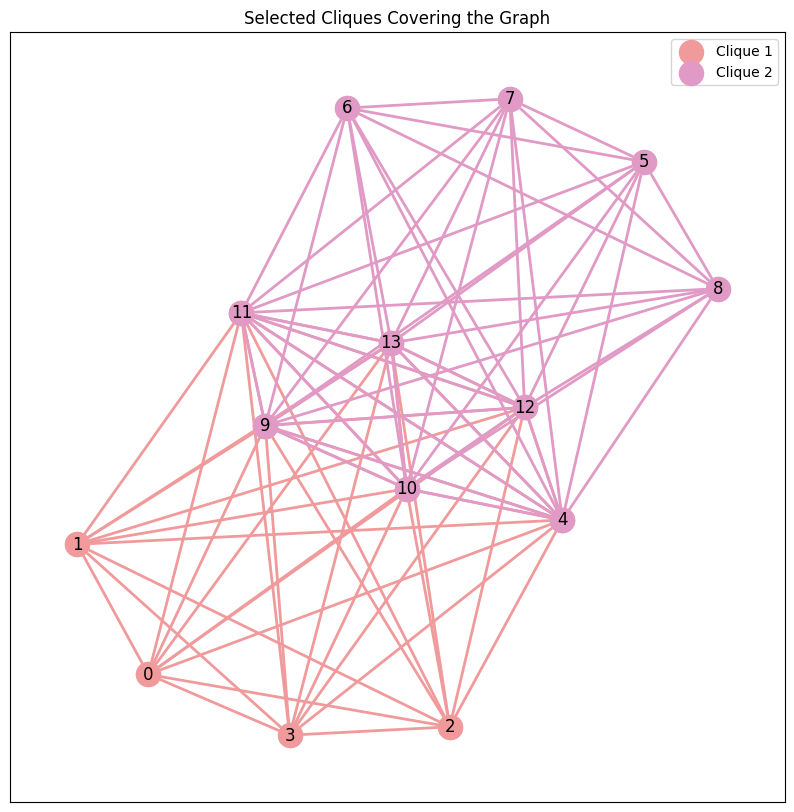

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.clique import find_cliques
from itertools import combinations
import time
import random

# Create your graph `H` here
# H = nx.Graph()
# Add nodes and edges to H as needed
# Example: H = nx.erdos_renyi_graph(10, 0.5)  # Random graph for demonstration

# Generate cliques
glocal_cliques = list(find_cliques(H))  # Find cliques in H

# Initialize the set of covered nodes
gcovered_nodes = set()
gselected_cliques = []

# Greedy algorithm to cover nodes with minimum number of cliques
def cover_nodes_with_cliques(gcliques, H):
    guncovered_nodes = set(H.nodes)
    gselected_cliques = []
    while guncovered_nodes:
        # Find the clique that covers the most uncovered nodes
        gbest_clique = None
        gbest_cover = 0
        for clique in gcliques:
            gcover = len(set(clique) & guncovered_nodes)
            if gcover > gbest_cover:
                gbest_cover = gcover
                gbest_clique = clique
        
        if gbest_clique is None:
            break
        
        # Add the best clique to the selected cliques
        gselected_cliques.append(gbest_clique)
        gcovered_nodes.update(gbest_clique)
        guncovered_nodes.difference_update(gbest_clique)
    
    return gselected_cliques

# Start measuring time
start_time = time.time()

# Find the minimum number of cliques to cover the entire graph
gselected_cliques = cover_nodes_with_cliques(glocal_cliques, H)

# End measuring time
end_time = time.time()
elapsed_time = end_time - start_time

# Print results
print("Minimum number of cliques to cover the entire graph:", len(gselected_cliques))
for clique in gselected_cliques:
    print(list(clique))

print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Visualization
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(H)  # Layout for visualization

# Draw nodes and edges
nx.draw_networkx_nodes(H, pos, node_color='lightgray', node_size=300)
nx.draw_networkx_edges(H, pos, edge_color='lightgray')

# Draw cliques with different colors
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(gselected_cliques))]
for i, clique in enumerate(gselected_cliques):
    nx.draw_networkx_nodes(H, pos, nodelist=clique, node_color=colors[i], node_size=300, label=f"Clique {i+1}")
    nx.draw_networkx_edges(H, pos, edgelist=[(clique[j], clique[k]) for j in range(len(clique)) for k in range(j+1, len(clique))], width=2, edge_color=colors[i])

# Draw node labels
nx.draw_networkx_labels(H, pos, font_size=12, font_color="black")

# Save the figure as an image file
plt.legend()
plt.title("Selected Cliques Covering the Graph")
plt.savefig("selected_cliques.png")
plt.show()


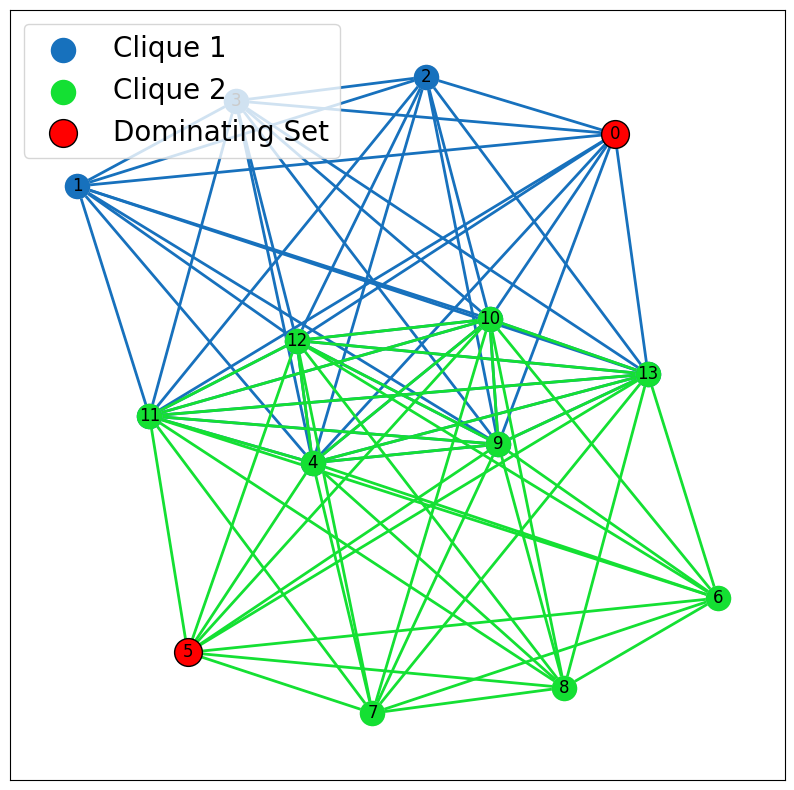

In [52]:
# Define the dominating set as nodes 0 and 5
dominating_set = [0, 5]

# Visualization
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(H)  # Layout for visualization

# Draw all nodes in light gray
nx.draw_networkx_nodes(H, pos, node_color='lightgray', node_size=300)
nx.draw_networkx_edges(H, pos, edge_color='lightgray')

# Draw cliques with different colors
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for _ in range(6)]) for _ in range(len(gselected_cliques))]
for i, clique in enumerate(gselected_cliques):
    nx.draw_networkx_nodes(H, pos, nodelist=clique, node_color=colors[i], node_size=300, label=f"Clique {i+1}")
    nx.draw_networkx_edges(H, pos, edgelist=[(clique[j], clique[k]) for j in range(len(clique)) for k in range(j+1, len(clique))], width=2, edge_color=colors[i])

# Highlight nodes 0 and 5 as the dominating set in red
nx.draw_networkx_nodes(H, pos, nodelist=dominating_set, node_color='red', node_size=400, edgecolors='black', label="Dominating Set")

# Draw node labels
nx.draw_networkx_labels(H, pos, font_size=12, font_color="black")

# Add a legend and title
plt.legend(scatterpoints=1, fontsize=20)
#plt.title("Graph with Highlighted Dominating Set (Nodes 0 and 5)")
plt.savefig("dominating_set_0_5_highlighted.png")
plt.show()


# End

In [33]:
print("Total number of cliques:", gtotal_cliques)
print("Average number of nodes in these cliques:", gaverage_nodes_in_cliques)

Total number of cliques: 2
Average number of nodes in these cliques: 10.0


# Cliques in QWC Graphs

In [ ]:
import time  # Import the time module


# Start measuring time
start_time = time.time()

# Find cliques in the graph
cliques = list(nx.find_cliques(G))
#print("Cliques:", cliques)

# End measuring time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time


print(f"Elapsed time: {elapsed_time:.4f} seconds")


# Draw the first 2 cliques
plt.figure(figsize=(10, 8))
for idx, clique in enumerate(cliques[:2]):
    plt.subplot(2, 1, idx + 1)
    subgraph = G.subgraph(clique)
    nx.draw(subgraph, with_labels=True, font_weight='bold')
    plt.title(f"Clique {idx + 1}")

plt.tight_layout()
plt.show()


total_cliques = len(cliques)
print("Total number of cliques:", total_cliques)



# Function to calculate the total weight of edges in a clique
def clique_weight(clique):
    return sum(G[u][v]['weight'] for u, v in nx.utils.pairwise(clique))

# Calculate the weights of all cliques
clique_weights = [(clique, clique_weight(clique)) for clique in cliques]

# Sort cliques by their total weight in descending order
sorted_cliques = sorted(clique_weights, key=lambda x: x[1], reverse=True)

# Print sorted cliques with their weights
for i, (clique, weight) in enumerate(sorted_cliques):
    print(f"Clique {i + 1}, Weight: {weight}")

# Draw the heaviest 2 cliques
plt.figure(figsize=(10, 8))
for idx, (clique, weight) in enumerate(sorted_cliques[:2]):
    plt.subplot(2, 1, idx + 1)
    subgraph = G.subgraph(clique)
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=True, font_weight='bold')
    edge_labels = nx.get_edge_attributes(subgraph, 'weight')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)
    plt.title(f"Heaviest Clique {idx + 1} (Weight: {weight})")

plt.tight_layout()
plt.show()


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a sample graph
G = nx.erdos_renyi_graph(10, 0.4, seed=1)  # Random graph with 10 nodes and edge probability 0.4

# Define a clique (fully connected subgraph)
# For demonstration, let's pick a random subset of nodes and assume it forms a clique
clique = [1, 2, 3]  # This should be a connected subset of nodes

# Define a dominating set (for demonstration)
# In a real case, you could calculate a minimum dominating set, here we select a few nodes
dominating_set = [0, 4, 7]

# Define positions for visual layout
pos = nx.spring_layout(G, seed=42)  # Positions nodes for visualization

# Plot the full graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_color='lightgray', node_size=500, edge_color='lightblue', font_size=12)

# Highlight the clique with one color
nx.draw_networkx_nodes(G, pos, nodelist=clique, node_color='skyblue', node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=[(clique[i], clique[j]) for i in range(len(clique)) for j in range(i+1, len(clique))],
                       width=3, edge_color='dodgerblue')

# Highlight the dominating set with another color
nx.draw_networkx_nodes(G, pos, nodelist=dominating_set, node_color='salmon', node_size=500, node_shape='s')

# Add a legend
plt.title("Graph Visualization with Clique and Dominating Set")
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Clique', markerfacecolor='skyblue', markersize=15)
red_patch = plt.Line2D([0], [0], marker='s', color='w', label='Dominating Set', markerfacecolor='salmon', markersize=15)
plt.legend(handles=[blue_patch, red_patch])

# Show and save the plot
plt.savefig("graph_clique_dominating_set.png")
plt.show()


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a sample graph with fewer nodes
G = nx.erdos_renyi_graph(7, 0.5, seed=1)  # Random graph with 7 nodes and edge probability 0.5

# Calculate a dominating set using NetworkX
dominating_set = list(nx.dominating_set(G))

# Define a clique (fully connected subgraph)
# We'll choose a maximal clique from the graph using NetworkX's find_cliques function
clique = list(next(nx.find_cliques(G)))

# Define positions for visual layout
pos = nx.spring_layout(G, seed=42)

# Set up the plot
plt.figure(figsize=(10, 10))
plt.gca().set_facecolor("white")  # Set background color to white

# Draw the full graph with high contrast
nx.draw(G, pos, with_labels=True, node_color='lightgray', node_size=1000,
        edge_color='lightblue', width=2, font_size=14, font_color='black')

# Highlight the clique with a distinct color (bright green)
nx.draw_networkx_nodes(G, pos, nodelist=clique, node_color='limegreen', node_size=1000)
nx.draw_networkx_edges(G, pos, edgelist=[(clique[i], clique[j]) for i in range(len(clique)) for j in range(i + 1, len(clique))],
                       width=3, edge_color='darkgreen')

# Highlight the dominating set with another high-contrast color (bright red)
nx.draw_networkx_nodes(G, pos, nodelist=dominating_set, node_color='red', node_size=1000, node_shape='s')

# Add a legend with high-contrast colors
plt.title("High-Contrast Graph Visualization with Clique and Dominating Set", fontsize=16)
clique_patch = plt.Line2D([0], [0], marker='o', color='w', label='Clique', markerfacecolor='limegreen', markersize=15)
dom_set_patch = plt.Line2D([0], [0], marker='s', color='w', label='Dominating Set', markerfacecolor='red', markersize=15)
plt.legend(handles=[clique_patch, dom_set_patch], fontsize=14)

# Show and save the plot
plt.savefig("high_contrast_graph_clique_dominating_set.png", dpi=300)
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a sample graph
G = nx.erdos_renyi_graph(10, 0.4, seed=1)  # Random graph with 10 nodes and edge probability 0.4

# Define a clique (fully connected subgraph)
clique = [1, 2, 3]  # This should be a connected subset of nodes forming a clique

# Define a dominating set
dominating_set = [0, 4, 7]

# Define positions for visual layout
pos = nx.spring_layout(G, seed=42)  # Positions nodes for visualization

# Plot the full graph
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_color='lightgray', node_size=500, edge_color='lightblue', font_size=12)

# Highlight the clique with one color
nx.draw_networkx_nodes(G, pos, nodelist=clique, node_color='skyblue', node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=[(clique[i], clique[j]) for i in range(len(clique)) for j in range(i+1, len(clique))],
                       width=3, edge_color='dodgerblue')

# Highlight the dominating set with another color
nx.draw_networkx_nodes(G, pos, nodelist=dominating_set, node_color='salmon', node_size=500, node_shape='s')

# Add a title and legend
plt.title("Graph Visualization Showing Nodes, Edges, Clique, and Dominating Set")
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Clique', markerfacecolor='skyblue', markersize=15)
red_patch = plt.Line2D([0], [0], marker='s', color='w', label='Dominating Set', markerfacecolor='salmon', markersize=15)
plt.legend(handles=[blue_patch, red_patch])

# Annotate a few edges and nodes directly
for (u, v) in G.edges():
    x, y = (pos[u][0] + pos[v][0]) / 2, (pos[u][1] + pos[v][1]) / 2  # Midpoint of the edge
    plt.text(x, y, 'Edge', fontsize=8, color='gray', ha='center')

# Annotate nodes individually
for node in G.nodes():
    plt.text(pos[node][0], pos[node][1] + 0.05, f'Node {node}', fontsize=10, color='black', ha='center')

# Add labels to distinguish nodes and edges conceptually
plt.text(0, -1.2, 'Nodes are the individual labeled points.', fontsize=12, color='black', ha='center')
plt.text(0, -1.3, 'Edges are the connections between nodes.', fontsize=12, color='gray', ha='center')

# Save the plot as an image file
plt.savefig("graph_with_clique_dominating_set_edges_nodes.png")
plt.show()


In [ ]:
import networkx as nx
import time  # Import the time module

#backtracking algorithm with high run time


# Start measuring time
start_time = time.time()


def find_cliques_with_node(G, clique):
    for neighbor in G.neighbors(clique[-1]):
        if neighbor not in clique and all(neighbor in G.neighbors(node) for node in clique):
            yield from find_cliques_with_node(G, clique + [neighbor])
    yield clique


def find_maximum_cliques(G):
    cliques = []
    max_clique_size = 0
    for node in G.nodes():
        for clique in find_cliques_with_node(G, [node]):
            if len(clique) > max_clique_size:
                cliques = [clique]
                max_clique_size = len(clique)
            elif len(clique) == max_clique_size and clique not in cliques:
                cliques.append(clique)
    return cliques

max_cliques = find_maximum_cliques(G)
print("Maximum cliques:", max_cliques)



# End measuring time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time


print(f"Elapsed time: {elapsed_time:.4f} seconds")

In [ ]:
#find maximum cliques based on dominating sets

import networkx as nx
from itertools import chain, combinations

def find_cliques_with_node(G, nodes):
    # Generator for finding cliques containing at least one of the specified nodes
    for clique in cliques:
        if any(node in clique for node in nodes):
            yield clique

def all_subsets(cliques):
    # Generate all possible subsets of a list
    return chain(*map(lambda x: combinations(cliques, x), range(1, len(cliques) + 1)))

def find_covering_cliques(G, ndominating_set):
    cliques_with_nodes = list(find_cliques_with_node(G, ndominating_set))
    best_covering_cliques = None
    
    # Check all subsets of cliques to find the minimum covering set
    for subset in all_subsets(cliques_with_nodes):
        covered_nodes = set()
        for clique in subset:
            covered_nodes.update(clique)
        if covered_nodes == set(G.nodes()):
            if best_covering_cliques is None or len(subset) < len(best_covering_cliques):
                best_covering_cliques = subset
    
    is_covering = best_covering_cliques is not None
    return list(best_covering_cliques) if is_covering else [], is_covering


max_cliques, is_covering = find_covering_cliques(G, ndominating_set)
print("Covering cliques:", max_cliques)
print("Is covering:", is_covering)


In [ ]:
#Finding Minimum Dominating Set by Integer Linear Programming (ILP) approach

from pulp import LpProblem, LpVariable, LpBinary, LpMinimize

def minimum_dominating_set_ilp(G):
    """
    This function uses Integer Linear Programming (ILP) to find an MDS.

    Args:
        G: A NetworkX graph object.

    Returns:
        A list of nodes representing the minimum dominating set.
    """
    prob = LpProblem("MinimumDominatingSet", LpMinimize)  # Use LpMinimize here

    # ... rest of the code remains the same ...

# Example usage
import networkx as nx
G = nx.karate_club_graph()  # Example graph
dominating_set = minimum_dominating_set_ilp(G)
print("Minimum Dominating Set (ILP):", dominating_set)



In [ ]:
#Finding Minimum Dominating Set by Greedy Approximation Approach

def minimum_dominating_set_greedy(G):
  """
  This function uses a greedy approximation algorithm to find an MDS.

  Args:
      G: A NetworkX graph object.

  Returns:
      A list of nodes representing an approximate dominating set.
  """
  dominating_set = []
  uncovered_nodes = set(G.nodes())

  while uncovered_nodes:
    # Find the node that covers the most uncovered neighbors
    max_coverage_node = None
    max_coverage = 0
    for v in uncovered_nodes:
      coverage = len(set(G.neighbors(v)) & uncovered_nodes)  # Corrected line
      if coverage > max_coverage:
        max_coverage_node = v
        max_coverage = coverage

    # Fix: Convert neighbors to set before intersection
    uncovered_nodes -= set(G.neighbors(max_coverage_node)) & uncovered_nodes

    # Add the node to the dominating set and update uncovered nodes
    dominating_set.append(max_coverage_node)

  return dominating_set



# Example usage
import networkx as nx
G = nx.karate_club_graph()  # Example graph
dominating_set = minimum_dominating_set_greedy(G)
print("Minimum Dominating Set (Greedy Approximation):", dominating_set)


In [ ]:
#Finding DS by algortihm proposed in paper


def greedy_k_dominating_set(graph, k):
  """
  This function implements a greedy heuristic algorithm to find a k-dominating set in a graph.

  Args:
      graph: A dictionary representing the graph. Keys are vertices, values are lists of adjacent vertices.
      k: An integer representing the size of the dominating set.

  Returns:
      A list of vertices representing the k-dominating set.
  """
  # Initialize an empty set to store the dominating set
  dominating_set = set()
  # Initialize a dictionary to store the number of uncovered neighbors for each vertex
  uncovered_neighbors = {vertex: len(graph[vertex]) for vertex in graph}

  # Sort the vertices by degree in descending order
  sorted_vertices = sorted(uncovered_neighbors, key=uncovered_neighbors.get, reverse=True)

  # Iterate through the vertices in the sorted order
  for vertex in sorted_vertices:
    # If the size of the dominating set reaches k, break the loop
    if len(dominating_set) == k:
      break

    # Add the vertex to the dominating set
    dominating_set.add(vertex)

    # Update the number of uncovered neighbors for all neighbors of the added vertex
    for neighbor in graph[vertex]:
      uncovered_neighbors[neighbor] -= 1

  # Return the dominating set
  return dominating_set


dominating_set = greedy_k_dominating_set(G, 1)
print(f"k-dominating set for k={1}: {dominating_set}")


# Cliques in GC Graph

In [ ]:

# Find cliques in the GC graph
cliques = list(nx.find_cliques(H))
#print("Cliques:", cliques)

# Draw the first 2 cliques
#plt.figure(figsize=(10, 8))
#for idx, clique in enumerate(cliques[:2]):
 #   plt.subplot(2, 1, idx + 1)
  #  subgraph = H.subgraph(clique)
   # nx.draw(subgraph, with_labels=True, font_weight='bold')
    #plt.title(f"Clique {idx + 1}")

#plt.tight_layout()
#plt.show()


total_cliques = len(cliques)
print("Total number of cliques:", total_cliques)

In [ ]:
import networkx as nx

# Find all maximal cliques
all_maximal_cliques = list(nx.find_cliques(G))

# Find the size of the maximum clique
max_clique_size = max(len(clique) for clique in all_maximal_cliques)

# Keep only the maximal cliques with the maximum size
max_cliques = [clique for clique in all_maximal_cliques if len(clique) == max_clique_size]

# Print the number of nodes for each maximum clique
print("Number of nodes in each maximum clique:")
for clique in max_cliques:
    print("Clique:", clique)
    print("Number of Nodes:", len(clique))

In [ ]:
import numpy as np  # Import numpy

# Define the `commute` function to check if two observables commute
#def commute(p, q):
 #   """ Check if two observables commute """
#functools.reduce(lambda x,y:x^y,np.logical_xor(np.logical_and(p.X,q.Z),np.logical_and(p.Z,q.X))[0,:])
# return np.allclose(commutator, 0)  # Check if commutator is close to zero


#def commute(p, q):
#    if np.allclose(p @ q, q @ p):  # Check for approximate equality first
#        return True
 #   else:
  #      # Check for exact commutation using Pauli matrix properties
   #     return (p @ q == -q @ p).all()


import functools
from functools import reduce


# PAULIS

# a class for storing sets of Pauli operators as pairs of symplectic matrices
class pauli:
    def __init__(observables,X,Z):
        # Inputs:
        #     X - (numpy.array) - X-part of Pauli in symplectic form with shape (p,q)
        #     Z - (numpy.array) - Z-part of Pauli in symplectic form with shape (p,q)
        if X.shape != Z.shape:
            raise Exception("X- and Z-parts must have same shape")
        observables.X = X
        observables.Z = Z

    # check whether self has only X component
    def is_IX(observables):
        # Outputs:
        #     (bool) - True if self has only X componenet, False otherwise
        return not np.any(observables.Z)

    # check whether self has only Z component 
    def is_IZ(observables):
        # Outputs:
        #     (bool) - True if self has only Z componenet, False otherwise
        return not np.any(observables.X)


# the symplectic inner product of two pauli objects (each with a single Pauli)
def symplectic_inner_product(P0,P1):
    # Inputs:
    #     P0 - (pauli) - must have shape (1,q)
    #     P1 - (pauli) - must have shape (1,q)
    # Outputs:
    #     (int) - symplectic inner product of Paulis modulo 2
    if (P0.paulis() != 1) or (P1.paulis() != 1):
        raise Exception("Symplectic inner product only works with pair of single Paulis")
    if P0.qubits() != P1.qubits():
        raise Exception("Symplectic inner product only works if Paulis have same number of qubits")
    return functools.reduce(lambda x,y:x^y,np.logical_xor(np.logical_and(P0.X,P1.Z),np.logical_and(P0.Z,P1.X))[0,:])


# check whether the set of Paulis are pairwise commuting
def is_commuting(observables):
        # Outputs:
        #     (bool) - True if self is pairwise commuting set of Paulis
        p = observables.paulis()
        PP = [observables.a_pauli(i) for i in range(p)]
        return not any(symplectic_inner_product(PP[i0],PP[i1]) for i0,i1 in itertools.combinations(range(p),2))



for i in range(len(observables)):
    for j in range(i + 1, len(observables)):
        result = is_commuting(observables)
        print(f"Observables {i} and {j} commute:", result)



# List to store commutativity results
#commutativity_results = []

# Loop through all pairs of observables
#for i in range(len(observables)):
 #   for j in range(i + 1, len(observables)):
  #      # Call the `commute` function to check if observables commute
   #     commutes = commute(observables[i], observables[j])
         # Append the result to the list
    #    commutativity_results.append((i, j, commutes))


        


In [ ]:
# the symplectic inner product of two pauli objects (each with a single Pauli)
def symplectic_inner_product(P0,P1):
    # Inputs:
    #     P0 - (pauli) - must have shape (1,q)
    #     P1 - (pauli) - must have shape (1,q)
    # Outputs:
    #     (int) - symplectic inner product of Paulis modulo 2
    if (P0.paulis() != 1) or (P1.paulis() != 1):
        raise Exception("Symplectic inner product only works with pair of single Paulis")
    if P0.qubits() != P1.qubits():
        raise Exception("Symplectic inner product only works if Paulis have same number of qubits")
    return functools.reduce(lambda x,y:x^y,np.logical_xor(np.logical_and(P0.X,P1.Z),np.logical_and(P0.Z,P1.X))[0,:])

In [ ]:
import numpy as np

# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

# Define identity matrix
identity = np.eye(2)

# Function to generate the matrix representation of a product of Pauli matrices
def pauli_product(matrix_string):
    """
    Generate the matrix representation of a product of Pauli matrices.

    Args:
    - matrix_string: A string representing the product of Pauli matrices,
                     e.g., 'ZII', 'XYY', etc.

    Returns:
    - The matrix representation of the product.
    """
    matrix = np.eye(2)
    for char in matrix_string:
        if char == 'X':
            matrix = np.kron(matrix, sigma_x)
        elif char == 'Y':
            matrix = np.kron(matrix, sigma_y)
        elif char == 'Z':
            matrix = np.kron(matrix, sigma_z)
        elif char == 'I':
            matrix = np.kron(matrix, identity)
        else:
            raise ValueError("Invalid character in matrix string. Use 'X', 'Y', 'Z', or 'I'.")
    return matrix

for i in range(len(observables)):
    matrix[i] = pauli_product(observables[i])
print(f"Matrix representation of {observables[i]}:\n{matrix[i]}")
# Example usage
#matrix_string = 'ZII'  # Change this string to represent different matrices




In [ ]:
import numpy as np

# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

# Define identity matrix
identity = np.eye(2)

# Mapping from integers to Pauli matrices
pauli_map = {0: identity, 1: sigma_x, 2: sigma_y, 3: sigma_z}


# Convert each observable to its corresponding matrix representation
observables_with_matrices = []


for observable in observables:
    matrix = np.eye(2)  # Start with the identity matrix
    for pauli_index in observable:
        matrix = np.kron(matrix, pauli_map[pauli_index])
    observables_with_matrices.append(matrix)

# Print the matrix representations of the observables
for i, matrix in enumerate(observables_with_matrices):
    print(f"Observable {i+1} matrix representation:")
    print(matrix)


import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def commutivity(O, P):
    """ Returns whether matrices O and P commute """
    commutator = np.dot(O, P) - np.dot(P, O)
    return np.allclose(commutator, np.zeros_like(commutator))

def check_commutativity(observables_with_matrices):
    """ Checks commutativity for a list of observables """
    n = len(observables_with_matrices)
    G = nx.Graph()
    for i in range(n):
        for j in range(i + 1, n):
            result = commutivity(observables_with_matrices[i], observables_with_matrices[j])
            print(f"Observables {i} and {j} commute:", result)
            if result:
                G.add_edge(i, j)
    return G

G = check_commutativity(observables)

# Plotting the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
plt.show()
